<a href="https://colab.research.google.com/github/ahamed-kashif/NLP_PROJECT_CSE_495/blob/main/CSE495_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets
### CSE495 (NLP) Project
#### Source of dataset https://appen.com/datasets-resource-center/

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import string
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [141]:
vocab_size = 100000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 6000


In [142]:
train_data = pd.read_csv("sample_data/train.csv")
test_data = pd.read_csv("sample_data/test.csv")
train_data.head()
train_data.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [143]:
train_data["text_clean"] = train_data["text"].apply(lambda x: x.lower())
test_data["text_clean"] = test_data["text"].apply(lambda x: x.lower())

#Special Characters Removal:
train_data['text_clean']= train_data['text_clean'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')
test_data['text_clean']= test_data['text_clean'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')
# Remove URL
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_URL(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_URL(x))

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_html(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_html(x))

def remove_emojis(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_emojis(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_emojis(x))

In [144]:
print(train_data["text_clean"])
print(test_data["text_clean"])

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       000 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610      m 00 utckm s of volcano hawaii httptcozdtoydebj
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_clean, Length: 7613, dtype: object
0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4             typhoon soudelor kills  in china and taiwan
                          

In [145]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

train_data['text'] = train_data['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
test_data['text'] = train_data['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [184]:
train_data.isnull().sum()
test_data.isnull().sum()
train_data['location'] = train_data['location'].fillna('None')
train_data['keyword'] = train_data['keyword'].fillna('None')
train_data['target'] = train_data['target'].fillna(0)
test_data['location'] = test_data['location'].fillna('None')
test_data['keyword'] = test_data['keyword'].fillna('None')


In [185]:
train_data.drop(columns=['id','location','keyword'])
test_data.drop(columns=['id','location','keyword'])

,text,text_clean
0,Our Deeds Reason #earthquake May ALLAH Forgive us,just happened a terrible car crash
1,Forest fire near La Ronge Sask. Canada,heard about earthquake is different cities sta...
2,All residents asked 'shelter place' notified o...,there is a forest fire at spot pond geese are ...
3,"13,000 people receive #wildfires evacuation or...",apocalypse lighting spokane wildfires
4,Just got sent photo Ruby #Alaska smoke #wildfi...,typhoon soudelor kills in china and taiwan
...,...,...
3258,Do feel engulfed low self-image? Take quiz: ht...,earthquake safety los angeles ûò safety fasten...
3259,Man equally incapable seeing nothingness emerg...,storm in ri worse than last hurricane my citya...
3260,Fully Engulfed Garage Fire: Propane Tanks Insi...,green line derailment in chicago httptcoutbxlc...
3261,He came land engulfed tribal war turned land p...,meg issues hazardous weather outlook hwo httpt...


In [193]:
sentences = train_data['text_clean']
labels = train_data['target']
training_sentences = train_data.loc[:training_size-1,'text_clean']
testing_sentences = train_data.loc[training_size:,'text_clean']
training_labels =  labels[0:training_size]
testing_labels = labels[training_size:]

In [187]:
print(testing_sentences)

6000    saku_uchiha_ ya_boi_luke \n\nscreams and gets ...
6001            heyot im not home i need to watch screams
6002    in light of recent events all i would like to ...
6003    so lawsonofficial just followed me and i canno...
6004         tiles zacb_ my dell tablet screams with win0
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610      m 00 utckm s of volcano hawaii httptcozdtoydebj
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_clean, Length: 1613, dtype: object


In [194]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_labels = training_labels
testing_labels = testing_labels

In [196]:
training_labels.shape

(6000,)

In [197]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [208]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [202]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 16)           1600000   
                                                                 
 global_average_pooling1d_9   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 24)                408       
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,600,433
Trainable params: 1,600,433
Non-trainable params: 0
_________________________________________________________________


In [209]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
188/188 - 3s - loss: 0.6796 - accuracy: 0.5805 - val_loss: 0.6893 - val_accuracy: 0.5325 - 3s/epoch - 18ms/step
Epoch 2/30
188/188 - 3s - loss: 0.6651 - accuracy: 0.5807 - val_loss: 0.6683 - val_accuracy: 0.5332 - 3s/epoch - 14ms/step
Epoch 3/30
188/188 - 3s - loss: 0.5907 - accuracy: 0.6903 - val_loss: 0.5881 - val_accuracy: 0.7210 - 3s/epoch - 15ms/step
Epoch 4/30
188/188 - 3s - loss: 0.4570 - accuracy: 0.8370 - val_loss: 0.5159 - val_accuracy: 0.7781 - 3s/epoch - 14ms/step
Epoch 5/30
188/188 - 4s - loss: 0.3597 - accuracy: 0.8703 - val_loss: 0.4878 - val_accuracy: 0.7843 - 4s/epoch - 19ms/step
Epoch 6/30
188/188 - 3s - loss: 0.2964 - accuracy: 0.8905 - val_loss: 0.4748 - val_accuracy: 0.7911 - 3s/epoch - 14ms/step
Epoch 7/30
188/188 - 3s - loss: 0.2474 - accuracy: 0.9113 - val_loss: 0.4875 - val_accuracy: 0.7805 - 3s/epoch - 15ms/step
Epoch 8/30
188/188 - 3s - loss: 0.2076 - accuracy: 0.9272 - val_loss: 0.4710 - val_accuracy: 0.7967 - 3s/epoch - 15ms/step
Epoch 9/30
188/1

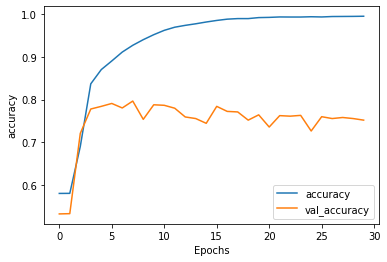

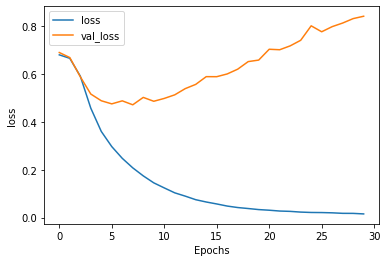

In [210]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [211]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [214]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              mask_zero=True, input_length=max_length,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=100),
    Dense(2)
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 16)           1600000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                270       
                                                                 
 dense_27 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1,600,292
Trainable params: 292
Non-trainable params: 1,600,000
_________________________________________________________________


In [215]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
188/188 - 8s - loss: 2.7558 - accuracy: 0.5112 - val_loss: 2.3685 - val_accuracy: 0.5462 - 8s/epoch - 45ms/step
Epoch 2/30
188/188 - 5s - loss: 1.6553 - accuracy: 0.5335 - val_loss: 0.9629 - val_accuracy: 0.5394 - 5s/epoch - 26ms/step
Epoch 3/30
188/188 - 5s - loss: 0.9003 - accuracy: 0.5330 - val_loss: 0.7996 - val_accuracy: 0.5301 - 5s/epoch - 26ms/step
Epoch 4/30
188/188 - 5s - loss: 0.7892 - accuracy: 0.5297 - val_loss: 0.7565 - val_accuracy: 0.5183 - 5s/epoch - 26ms/step
Epoch 5/30
188/188 - 5s - loss: 0.7546 - accuracy: 0.5173 - val_loss: 0.7397 - val_accuracy: 0.5115 - 5s/epoch - 26ms/step
Epoch 6/30
188/188 - 5s - loss: 0.7362 - accuracy: 0.5038 - val_loss: 0.7273 - val_accuracy: 0.5084 - 5s/epoch - 26ms/step
Epoch 7/30
188/188 - 5s - loss: 0.7249 - accuracy: 0.4977 - val_loss: 0.7205 - val_accuracy: 0.5046 - 5s/epoch - 26ms/step
Epoch 8/30
188/188 - 5s - loss: 0.7185 - accuracy: 0.4903 - val_loss: 0.7156 - val_accuracy: 0.5015 - 5s/epoch - 26ms/step
Epoch 9/30
188/1

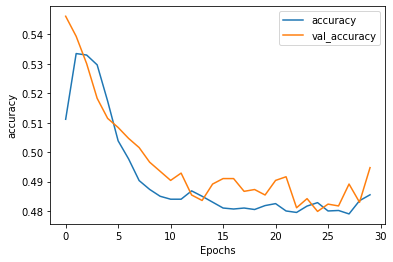

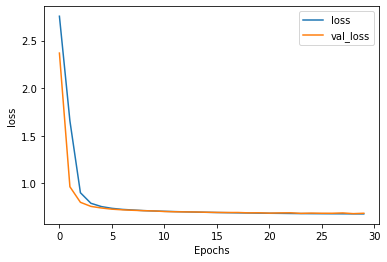

In [216]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [219]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              mask_zero=True, input_length=max_length,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=100),
    Dense(2)
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 16)           1600000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               11700     
                                                                 
 dense_29 (Dense)            (None, 2)                 202       
                                                                 
Total params: 1,611,902
Trainable params: 11,902
Non-trainable params: 1,600,000
_________________________________________________________________


In [220]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
188/188 - 8s - loss: 0.9381 - accuracy: 0.5073 - val_loss: 0.7085 - val_accuracy: 0.5127 - 8s/epoch - 45ms/step
Epoch 2/30
188/188 - 7s - loss: 0.6867 - accuracy: 0.4952 - val_loss: 0.6943 - val_accuracy: 0.5195 - 7s/epoch - 37ms/step
Epoch 3/30
188/188 - 7s - loss: 0.6711 - accuracy: 0.4967 - val_loss: 0.6895 - val_accuracy: 0.5313 - 7s/epoch - 37ms/step
Epoch 4/30
188/188 - 7s - loss: 0.6686 - accuracy: 0.4997 - val_loss: 0.6884 - val_accuracy: 0.5263 - 7s/epoch - 37ms/step
Epoch 5/30
188/188 - 7s - loss: 0.6572 - accuracy: 0.4918 - val_loss: 0.7422 - val_accuracy: 0.5257 - 7s/epoch - 37ms/step
Epoch 6/30
188/188 - 7s - loss: 0.6625 - accuracy: 0.4950 - val_loss: 0.6852 - val_accuracy: 0.5226 - 7s/epoch - 37ms/step
Epoch 7/30
188/188 - 7s - loss: 0.6502 - accuracy: 0.4882 - val_loss: 0.7084 - val_accuracy: 0.5239 - 7s/epoch - 37ms/step
Epoch 8/30
188/188 - 7s - loss: 0.6576 - accuracy: 0.4865 - val_loss: 0.7378 - val_accuracy: 0.4941 - 7s/epoch - 37ms/step
Epoch 9/30
188/1

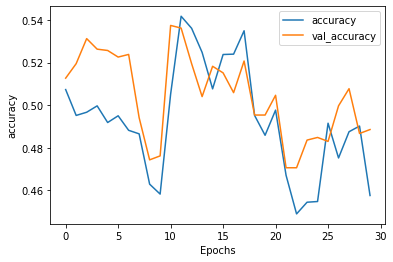

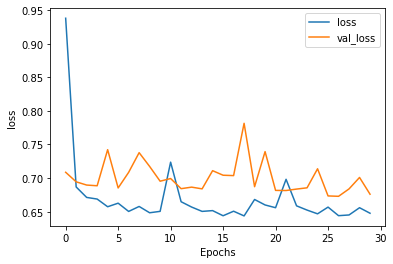

In [221]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [205]:
sequences = tokenizer.texts_to_sequences(test_data['text_clean'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
print()

In [206]:
submission_df = pd.read_csv('sample_data/predict.csv')
submission_df['target'] = pred
submission_df.to_csv('submission.csv', index=False)
result = pd.read_csv('submission.csv')

In [207]:
print(result)

         id    target
0         0  0.064976
1         2  0.574196
2         3  0.997821
3         9  0.971281
4        11  0.995779
...     ...       ...
3258  10861  0.845373
3259  10865  0.997646
3260  10868  0.994799
3261  10874  0.971458
3262  10875  0.948157

[3263 rows x 2 columns]


In [119]:
model.predict()

ValueError: ignored